In [1]:
import pandas as pd
import s3fs

In [2]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

FILE_PATH_S3_FVDEP = f"{MY_BUCKET}/diffusion/epci_6_clusters.csv"
with fs.open(FILE_PATH_S3_FVDEP, "rb") as file:
    epci_features = pd.read_csv(file)


In [3]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,distance_entrant_50<x<infkm_rouge,nb_sortant_50<x<infkm_rouge,distance_sortant_50<x<infkm_rouge,nb_intra_rouge,distance_intra_rouge,total_entrants,total_sortants,sortant_sur_entrant,cluster,color
506,506,524,524,200069565,"['Châtelblanc', 'Petite-Chaux', 'Les Pontets',...","['25131', '25451', '25464', '25320', '25121', ...","['25', '25', '25', '25', '25', '25', '25', '25...",16407.0,2277.859921,7264.43543,...,77323.572762,120.165342,19323.121323,1618.070959,9179.45886,1437.621308,867.955224,0.603744,3,"(np.float64(0.12156862745098039), np.float64(0..."


étape 1 : Il faut choisir un clustering parmi les 4 (on demandera l'avis de Nicolas) et pour chaque cluster trouver une composition moyenne des transports en communs utilisé (ex 80% metro et 10% train et 10% bus pour le cluster ou y'a que paris, etc)

étape 2 : Il faut écrire un dictionnaire qui recense pour chaque type de transport en commun son émission moy/km 

étape 3 : Créer une nouvelle colonne sur un des 4 tableaux (selon le clustering retenu) qui donnerait une émission moyenne pour chaque EPCI (soit global, soit par type de flux (séparer rouge et jaune? à voir))

-> pour cette étape voir si + pertinent de prendre les flux entrant ou sortant ? ou une moyenne des 2 ?

étape 4 : trouver un moyen de repérer les mauvais élèves (par exemple ceux dont l'émission associée calculée est aberrante ou plus élevée par rapport aux autres EPCI du même cluster)

-> pour cette étape trouver un indicateurs pour détecter les mauvais élève (ex arbitraire 50% aus dessus de la moyenne) mais voir si on peut trouver un meilleur indicateur bien justifier

In [4]:
'''
# Etape 1

# Pour l'instant choix du clustering à 7 clusters
# On prend en compte à la fois les flux entrants et les flux sortants pour faire les calculs

epci_features=epci_features_7 # il suffira de changer le numéro du clustering choisi ici

epci_features["nombre_total_de_flux_par_epci"]=(
    epci_features["nb_entrant_>50km_rouge"]
    +epci_features["nb_entrant_<50km_rouge"]
    +epci_features["nb_sortant_>50km_rouge"]
    +epci_features["nb_sortant_<50km_rouge"]
    +epci_features["nb_intra_rouge"]
    +epci_features["nb_entrant_>50km_vert"]
    +epci_features["nb_entrant_<50km_vert"]
    +epci_features["nb_sortant_>50km_vert"]
    +epci_features["nb_sortant_<50km_vert"]
    +epci_features["nb_intra_vert"]
    +epci_features["nb_entrant_>50km_jaune"]
    +epci_features["nb_entrant_<50km_jaune"]
    +epci_features["nb_sortant_>50km_jaune"]
    +epci_features["nb_sortant_<50km_jaune"]
    +epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en voiture
epci_features["proportion_individus_flux_rouges"] = (
    (epci_features["nb_entrant_>50km_rouge"]
    + epci_features["nb_entrant_<50km_rouge"]
    + epci_features["nb_sortant_>50km_rouge"]
    + epci_features["nb_sortant_<50km_rouge"]
    + epci_features["nb_intra_rouge"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en transports en commun
epci_features["proportion_individus_flux_jaunes"] = (
    (epci_features["nb_entrant_>50km_jaune"]
    + epci_features["nb_entrant_<50km_jaune"]
    + epci_features["nb_sortant_>50km_jaune"]
    + epci_features["nb_sortant_<50km_jaune"]
    + epci_features["nb_intra_jaune"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_individus_flux_verts"] = (
    (epci_features["nb_entrant_>50km_vert"]
    + epci_features["nb_entrant_<50km_vert"]
    + epci_features["nb_sortant_>50km_vert"]
    + epci_features["nb_sortant_<50km_vert"]
    + epci_features["nb_intra_vert"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

print(epci_features["proportion_individus_flux_rouges"].head())
print(epci_features["proportion_individus_flux_jaunes"].head())
print(epci_features["proportion_individus_flux_verts"].head())
print(epci_features["proportion_individus_flux_rouges"].head()
    +epci_features["proportion_individus_flux_jaunes"].head()
    +epci_features["proportion_individus_flux_verts"].head())
# les résultats sont parfaitement logiques ici
'''

'\n# Etape 1\n\n# Pour l\'instant choix du clustering à 7 clusters\n# On prend en compte à la fois les flux entrants et les flux sortants pour faire les calculs\n\nepci_features=epci_features_7 # il suffira de changer le numéro du clustering choisi ici\n\nepci_features["nombre_total_de_flux_par_epci"]=(\n    epci_features["nb_entrant_>50km_rouge"]\n    +epci_features["nb_entrant_<50km_rouge"]\n    +epci_features["nb_sortant_>50km_rouge"]\n    +epci_features["nb_sortant_<50km_rouge"]\n    +epci_features["nb_intra_rouge"]\n    +epci_features["nb_entrant_>50km_vert"]\n    +epci_features["nb_entrant_<50km_vert"]\n    +epci_features["nb_sortant_>50km_vert"]\n    +epci_features["nb_sortant_<50km_vert"]\n    +epci_features["nb_intra_vert"]\n    +epci_features["nb_entrant_>50km_jaune"]\n    +epci_features["nb_entrant_<50km_jaune"]\n    +epci_features["nb_sortant_>50km_jaune"]\n    +epci_features["nb_sortant_<50km_jaune"]\n    +epci_features["nb_intra_jaune"]\n    )\n\n# Calcul de la proportion

In [5]:
'''
# Même chose avec la distance

epci_features["distance_totale_de_flux_par_epci"]=(
    epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"]
    + epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"]
    + epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en voiture
epci_features["proportion_distance_flux_rouges"] = (
    (epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en transports en commun
epci_features["proportion_distance_flux_jaunes"] = (
    (epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_distance_flux_verts"] = (
    (epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

print(epci_features["proportion_distance_flux_rouges"].head())
print(epci_features["proportion_distance_flux_rouges"].mean())
print(epci_features["proportion_distance_flux_jaunes"].head())
print(epci_features["proportion_distance_flux_jaunes"].mean())
print(epci_features["proportion_distance_flux_verts"].head())
print(epci_features["proportion_distance_flux_verts"].mean())
print((epci_features["proportion_distance_flux_rouges"]+epci_features["proportion_distance_flux_jaunes"]+epci_features["proportion_distance_flux_verts"]).head())
# La somme de toutes les proportions fait 1
# Les résultats sont logiques
'''

'\n# Même chose avec la distance\n\nepci_features["distance_totale_de_flux_par_epci"]=(\n    epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]\n    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]\n    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]\n    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]\n    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"]\n    + epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]\n    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]\n    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]\n    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]\n    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"]\n    + epci_features["dist

In [3]:
# Etape 2

# SOURCE : https://www.data.gouv.fr/fr/datasets/emission-de-co2e-par-voyageur-kilometre-sur-le-reseau/

pollution_au_km={
    "voiture":"0.097", 
    "bus":"0.092", 
    "metro":"0.0038",
    "tram":"0.0032",
    "transilien":"0.0066",
    "TER":"0.02693"
}

In [9]:
# CALCUL EMISSIONS TOTALES 

pollution_au_km_flux_jaunes ={
    "Bus": 0.092, 
    "Métro/tram/transilien": 0.0045,
    "TER": 0.02693
}

pollution_au_km_flux_rouges = 0.144

# Dictionnaire avec les valeurs choisies pour chaque mode de TC en % de la distance parcourue en TC 

flux_jaunes_detail = {
    0 : { #Villes moyennes
        "Métro/tram/transilien": 0.2,
        "TER": 0.4,   
        "Bus": 0.4   
    },
    1 : { #Banlieue Paris
        "Métro/tram/transilien": 0.7,  
        "TER": 0.1,    
        "Bus": 0.2    
    },
    2 : { #Paris
        "Métro/tram/transilien": 0.8,  
        "TER": 0.1,   
        "Bus": 0.1   
    },
    3 : { #Autres
        "Métro/tram/transilien": 0, 
        "TER": 0.5,    
        "Bus": 0.5     
    },
    4 : { #Grandes villes
        "Métro/tram/transilien" : 0.5,
        "TER" : 0.2,
        "Bus" : 0.3
    },
    5 : { # Banlieue proche Paris
        "Métro/tram/transilien" : 0.7,
        "TER" : 0.1,
        "Bus" : 0.2
    }
}


# ici flux intra + moyenne des flux sortants et entrants 
epci_features["moyenne_flux_rouges"] = (
    epci_features['distance_intra_rouge'] +(
    epci_features['distance_entrant_<10km_rouge'] + 
    epci_features['distance_entrant_10<x<20km_rouge'] + 
    epci_features['distance_entrant_20<x<30km_rouge']  +
    epci_features['distance_entrant_30<x<40km_rouge'] + 
    epci_features['distance_entrant_40<x<50km_rouge']+ 
    epci_features['distance_entrant_50<x<infkm_rouge']  + 
    epci_features['distance_sortant_<10km_rouge']  + 
    epci_features['distance_sortant_10<x<20km_rouge']  + 
    epci_features['distance_sortant_20<x<30km_rouge'] +
    epci_features['distance_sortant_30<x<40km_rouge']+ 
    epci_features['distance_sortant_40<x<50km_rouge']+ 
    epci_features['distance_sortant_50<x<infkm_rouge'])/2)
    

epci_features['pollution_flux_rouges'] = epci_features['moyenne_flux_rouges'] * pollution_au_km_flux_rouges

epci_features["moyenne_flux_jaunes"] = (
    epci_features['distance_intra_jaune']+ (
    epci_features['distance_entrant_<10km_jaune']+ 
    epci_features['distance_entrant_10<x<20km_jaune'] + 
    epci_features['distance_entrant_20<x<30km_jaune'] +
    epci_features['distance_entrant_30<x<40km_jaune'] + 
    epci_features['distance_entrant_40<x<50km_jaune'] + 
    epci_features['distance_entrant_50<x<infkm_jaune'] + 
    epci_features['distance_sortant_<10km_jaune'] + 
    epci_features['distance_sortant_10<x<20km_jaune']  + 
    epci_features['distance_sortant_20<x<30km_jaune']+
    epci_features['distance_sortant_30<x<40km_jaune'] + 
    epci_features['distance_sortant_40<x<50km_jaune'] + 
    epci_features['distance_sortant_50<x<infkm_jaune'])/2)


for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Appliquer la répartition pour chaque mode de transport en fonction du cluster
    epci_features[f'distance_{transport}'] = epci_features['moyenne_flux_jaunes'] * \
        epci_features['cluster'].map(lambda cluster: flux_jaunes_detail.get(cluster, {}).get(transport, 0))

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Calculer la pollution en multipliant la distance par les émissions par km pour chaque mode
    epci_features[f'pollution_{transport}'] = epci_features[f'distance_{transport}'] * pollution_au_km_flux_jaunes[transport]

epci_features['pollution_flux_jaunes'] = (
    epci_features['pollution_Métro/tram/transilien'] + epci_features['pollution_TER'] + 
    epci_features['pollution_Bus']) 

epci_features['pollution_totale'] = (
    epci_features['pollution_flux_rouges'] + epci_features['pollution_flux_jaunes'])


In [10]:
epci_features[epci_features['cluster']==2]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale
256,256,269,269,200054781,"['Paris 2e Arrondissement', 'Paris 9e Arrondis...","['75102', '75109', '75111', '75117', '75103', ...","['75', '75', '75', '75', '75', '75', '75', '75...",2145906.0,161930.110098,1.128286e+06,...,1.299888e+06,1.861650e+07,1.489320e+07,1.861650e+06,1.861650e+06,67019.416486,50134.246832,171271.842131,288425.50545,1.588313e+06


In [9]:
'''
# Identifier les mauvais élèves

# Trier les EPCI par pollution totale dans chaque cluster
mauvais_eleves_par_cluster = epci_features.sort_values(['cluster', 'pollution_flux_rouges'], ascending=[True, False])

# Garder les 5 pires par cluster
top_n = 5
mauvais_eleves_par_cluster = mauvais_eleves_par_cluster.groupby('cluster').head(top_n)

cols = ['cluster', 'NOM', 'pollution_flux_rouges']
print(mauvais_eleves_par_cluster[cols])
'''

"\n# Identifier les mauvais élèves\n\n# Trier les EPCI par pollution totale dans chaque cluster\nmauvais_eleves_par_cluster = epci_features.sort_values(['cluster', 'pollution_flux_rouges'], ascending=[True, False])\n\n# Garder les 5 pires par cluster\ntop_n = 5\nmauvais_eleves_par_cluster = mauvais_eleves_par_cluster.groupby('cluster').head(top_n)\n\ncols = ['cluster', 'NOM', 'pollution_flux_rouges']\nprint(mauvais_eleves_par_cluster[cols])\n"

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pollution_par_cluster(df, cluster_id, label_col='SIREN_EPCI'):
    """
    Affiche un barplot de la pollution totale pour un cluster donné.

    Paramètres :
        df : DataFrame contenant les colonnes 'cluster' et 'pollution_totale'
        cluster_id : identifiant du cluster à visualiser
        label_col : colonne à afficher sur l'axe des y (par défaut 'INSEE_COM')
    """
    # Filtrer le cluster
    subset = df[df['cluster'] == cluster_id].copy()

    if subset.empty:
        print(f"Aucun EPCI trouvé pour le cluster {cluster_id}")
        return
    # Trier du moins au plus polluant
    subset = subset.sort_values('pollution_totale', ascending=True)

    # Créer le barplot
    hauteur = max(6, len(subset) * 0.4)  # 0.4 par ligne, minimum 6
    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(
        data=subset,
        x='pollution_totale',
        y=label_col,
        palette='Reds')

    plt.title(f"Pollution totale – Cluster : {cluster_id}")
    plt.xlabel("kg CO₂")
    plt.ylabel("EPCI")

    # Affichage des valeurs sur les barres
    for container in barplot.containers:
        barplot.bar_label(container, label_type="edge", padding=3)

    plt.tight_layout()
    plt.show()


In [12]:
mauvais_eleves = []

for cluster_id in epci_features['cluster'].unique():
    # On sélectionne les lignes du cluster
    groupe = epci_features[epci_features['cluster'] == cluster_id]
    seuil = groupe['pollution_flux_rouges'].mean() + 2*groupe['pollution_flux_rouges'].std()
    mauvais = groupe[groupe['pollution_flux_rouges'] > seuil]
    mauvais_eleves.append(mauvais)

# On concatène tous les mauvais élèves en un seul DataFrame
mauvais_eleves_par_cluster = pd.concat(mauvais_eleves)


In [13]:
mauvais_eleves_par_cluster['cluster']

245    3
366    3
472    3
549    3
601    3
689    3
758    3
831    3
840    3
841    3
842    3
844    3
882    3
45     0
830    0
836    0
843    0
262    5
270    1
Name: cluster, dtype: int64

/tmp/ipykernel_19970/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


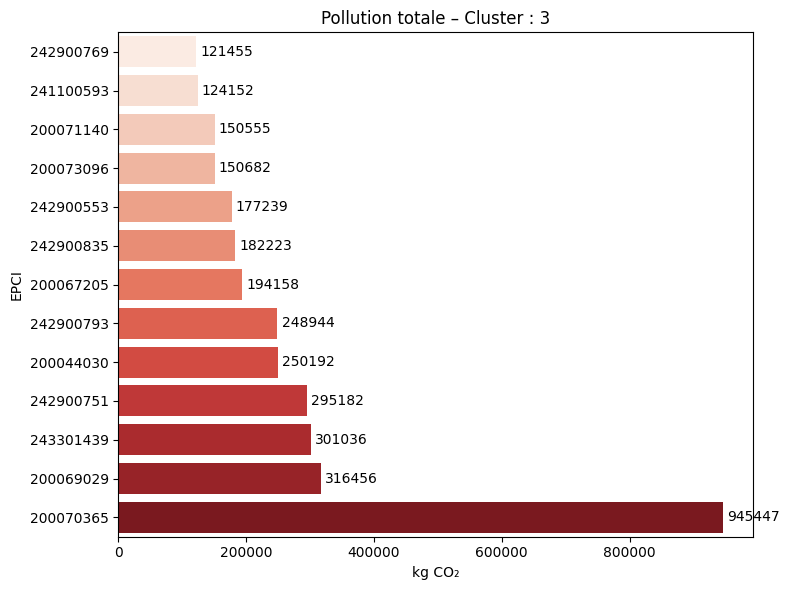

None


/tmp/ipykernel_19970/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


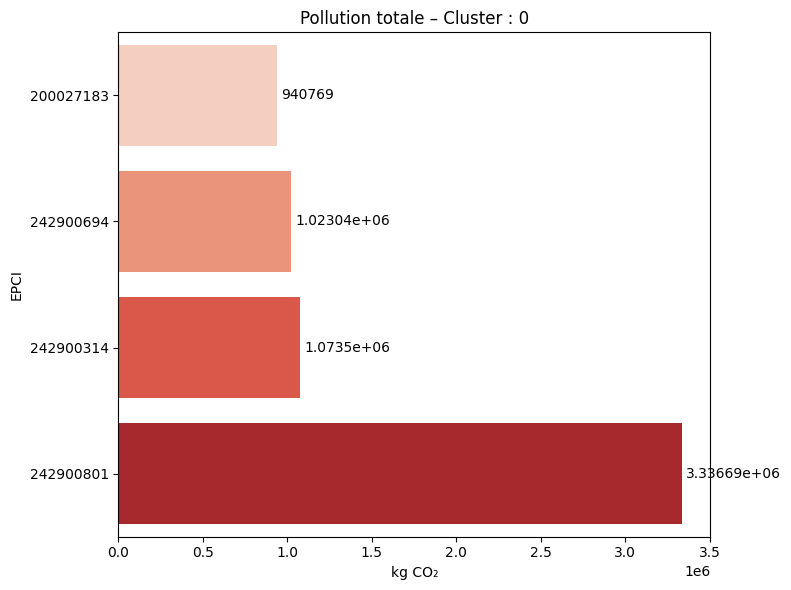

/tmp/ipykernel_19970/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


None


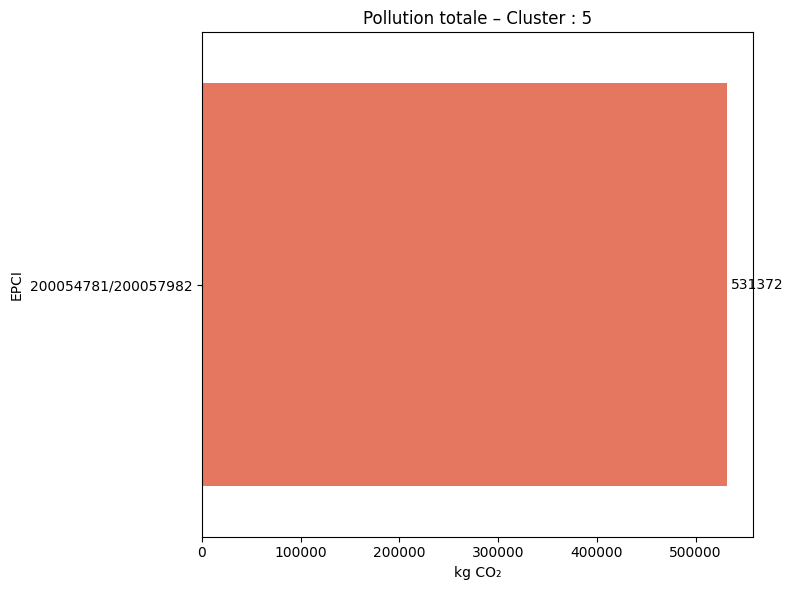

None


/tmp/ipykernel_19970/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


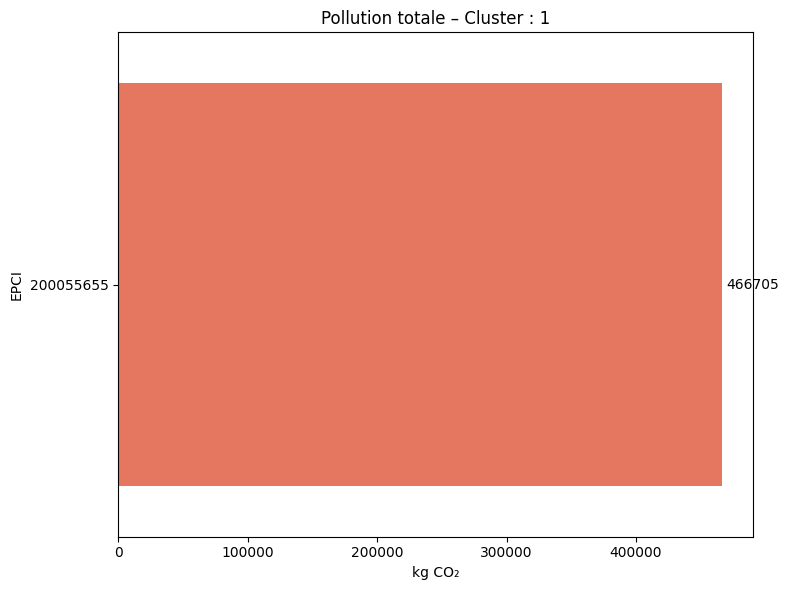

None


In [14]:
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=3))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=0))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=5))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=1))

In [14]:
# Faire la partie simulation de réduction des émissions via politique de décarbonation

# BONUS : étude socio

In [16]:
from script import df_dossier_complet_brut
from script import df_meta_dossier_complet_brut

/home/onyxia/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/statapp/script.py:151: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Us

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [16]:
df_meta_dossier_complet_brut['THEME'].unique()

array(['Évolution et structure de la population',
       'Couples - Familles - Ménages', 'Logement', 'Diplômes - Formation',
       'Population active, emploi et chômage au sens du recensement',
       "Caractéristiques de l'emploi au sens du recensement",
       'Naissances et décès domiciliés',
       'Revenus et pauvreté des ménages',
       "Salaires et revenus d'activité",
       'Caractéristiques des établissements',
       'Démographie des entreprises', 'Tourisme', nan], dtype=object)

In [17]:
var_socio = ["MED21","TP6021","D121","D921","RD21","SNHM22"]

In [18]:
df_meta_dossier_complet_brut.loc[df_meta_dossier_complet_brut['COD_VAR'].isin(var_socio)]

,Unnamed: 0,COD_VAR,LIB_VAR,LIB_VAR_LONG,COD_MOD,LIB_MOD,TYPE_VAR,LONG_VAR,THEME,SOURCE
1544,1544,MED21,Médiane du niveau vie (€),Médiane du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1546,1546,TP6021,Taux de pauvreté-Ensemble (%),Taux de pauvreté-Ensemble (%),NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1566,1566,D121,1er décile du niveau de vie (€),1er décile du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1567,1567,D921,9e décile du niveau de vie (€),9e décile du niveau de vie (€),NaN,NaN,CHAR,6,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1568,1568,RD21,Rapport interdécile 9e décile/1er décile,Rapport interdécile 9e décile/1er décile,NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1569,1569,SNHM22,Salaire net horaire moyen en 2022 (€),Salaire net horaire moyen en 2022 (€),NaN,NaN,NUM,16,Salaires et revenus d'activité,"Insee, Bases Tous salariés, fichier salariés a..."


In [19]:
import numpy as np
df_dossier_complet_brut[var_socio] = df_dossier_complet_brut[var_socio].replace('s', np.nan)
df_dossier_complet_brut[var_socio].isna().mean() * 100

MED21     10.507816
TP6021    87.400337
D121      84.682651
D921      84.682651
RD21      84.682651
SNHM22    84.374018
dtype: float64

On retient MED21 qui a le moins de valeurs manquantes

In [20]:
df_dossier_complet_brut['MED21']

0        25820
1        24480
2        21660
3        24610
4        24210
         ...  
34988      NaN
34989      NaN
34990      NaN
34991      NaN
34992      NaN
Name: MED21, Length: 34993, dtype: object

In [21]:
df_dossier_complet_brut.sample()

,Unnamed: 0,CODGEO,P21_POP,P21_POP0014,P21_POP1529,P21_POP3044,P21_POP4559,P21_POP6074,P21_POP7589,P21_POP90P,...,CPGEO524,VV24,VVUH24,VVLIT24,RT24,RTUH24,RTLIT24,AJCS24,AJCSUH24,AJCSLIT24
12058,12058,32217,60.0,0.952381,2.857143,5.714286,14.285714,22.857143,11.428571,1.904762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_socio = df_dossier_complet_brut[['MED21', 'CODGEO']]

In [23]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale
240,240,251,251,200043776,"['Roquefort-de-Sault', 'Campagna-de-Sault', 'G...","['11321', '11062', '11165', '11265', '11080', ...","['11', '11', '11', '11', '11', '11', '11', '11...",13665.0,1094.357375,7131.601554,...,4569.258522,864.061429,0.0,432.030714,432.030714,0.0,11.634587,39.746826,51.381413,4620.639935


In [24]:
import re

# 1. Préparation des données
# Convertir la colonne INSEE_COM en liste de codes géographiques
def extract_codgeo_list(insee_com_str):
    if isinstance(insee_com_str, str):
        # Utiliser regex pour extraire tous les codes numériques
        codes = re.findall(r'\d+', insee_com_str)
        return codes
    return []

epci_features['CODGEO_LIST'] = epci_features['INSEE_COM'].apply(extract_codgeo_list)


In [25]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale,CODGEO_LIST
386,386,404,404,200067502,"['Erstroff', 'Eincheville', 'Leyviller', 'Vill...","['57198', '57189', '57398', '57717', '57224', ...","['57', '57', '57', '57', '57', '57', '57', '57...",52419.0,3551.45537,23250.89325,...,16065.299532,0.0,8032.649766,8032.649766,0.0,216.319258,739.003778,955.323037,28981.592818,"[57198, 57189, 57398, 57717, 57224, 57684, 572..."


In [26]:
# 2. Créer un dictionnaire de correspondance CODGEO -> SIREN_EPCI
codgeo_to_siren = {}
for _, row in epci_features.iterrows():
    siren = row['SIREN_EPCI']
    for codgeo in row['CODGEO_LIST']:
        codgeo_to_siren[codgeo] = siren


In [27]:
# 3. Ajouter la colonne SIREN_EPCI au dataframe df_socio
df_socio['SIREN_EPCI'] = df_socio['CODGEO'].map(codgeo_to_siren)


/tmp/ipykernel_23931/3801065909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['SIREN_EPCI'] = df_socio['CODGEO'].map(codgeo_to_siren)


In [28]:
df_socio['MED21'] = pd.to_numeric(df_socio['MED21'], errors='coerce')

/tmp/ipykernel_23931/4009060659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['MED21'] = pd.to_numeric(df_socio['MED21'], errors='coerce')


In [29]:

# 4. Calculer la moyenne de MED21 pour chaque EPCI
med21_mean_by_epci = df_socio.groupby('SIREN_EPCI')['MED21'].mean().reset_index()
med21_mean_by_epci.rename(columns={'MED21': 'MED21_MEAN'}, inplace=True)


In [30]:
# 5. Fusionner cette moyenne avec le dataframe epci_features
epci_features = epci_features.merge(med21_mean_by_epci, on='SIREN_EPCI', how='left')


In [31]:

# 6. Traiter les valeurs NaN dans MED21_MEAN
# Extraire le département à partir de CODGEO (les 2 ou 3 premiers chiffres selon le format)
def extract_dept(codgeo):
    if isinstance(codgeo, str):
        if codgeo.startswith('97'):
            return codgeo[:3]  # DOM-TOM
        else:
            return codgeo[:2]  # Métropole
    return None

# Ajouter la colonne département au df_socio
df_socio['DEPT'] = df_socio['CODGEO'].apply(extract_dept)

# Calculer la moyenne par département
med21_mean_by_dept = df_socio.groupby('DEPT')['MED21'].mean().reset_index()
med21_mean_by_dept.rename(columns={'MED21': 'MED21_MEAN_DEPT'}, inplace=True)

# Créer une correspondance département -> EPCI
epci_features['DEPT'] = epci_features['CODGEO_LIST'].apply(
    lambda x: extract_dept(x[0]) if x else None
)

# Fusionner la moyenne départementale avec epci_features
epci_features = epci_features.merge(med21_mean_by_dept, on='DEPT', how='left')

# Remplacer les NaN dans MED21_MEAN par la moyenne départementale
epci_features['MED21_MEAN'] = epci_features['MED21_MEAN'].fillna(epci_features['MED21_MEAN_DEPT'])

/tmp/ipykernel_23931/4063085231.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socio['DEPT'] = df_socio['CODGEO'].apply(extract_dept)


In [32]:
# 7. Pour les EPCI qui n'ont toujours pas de valeur MED21_MEAN, on peut utiliser la moyenne nationale
# S'assurer que nous calculons la moyenne uniquement sur les valeurs non-NaN
med21_national_mean = df_socio['MED21'].dropna().mean()
# Vérifier si la moyenne nationale existe avant de l'utiliser
if not pd.isna(med21_national_mean):
    epci_features['MED21_MEAN'] = epci_features['MED21_MEAN'].fillna(med21_national_mean)


In [38]:
pd.set_option('display.max_columns', None)


In [33]:
epci_features['MED21_MEAN']

0       28671.428571
1       22530.000000
2       21503.333333
3       22228.000000
4       22861.666667
            ...     
1220    30350.714286
1221    29200.000000
1222    25682.222222
1223    27186.400000
1224    23120.000000
Name: MED21_MEAN, Length: 1225, dtype: float64

In [39]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,INSEE_COM_list,INSEE_DEP_list,nb_entrant_<10km_vert,distance_entrant_<10km_vert,nb_sortant_<10km_vert,distance_sortant_<10km_vert,nb_entrant_10<x<20km_vert,distance_entrant_10<x<20km_vert,nb_sortant_10<x<20km_vert,distance_sortant_10<x<20km_vert,nb_entrant_20<x<30km_vert,distance_entrant_20<x<30km_vert,nb_sortant_20<x<30km_vert,distance_sortant_20<x<30km_vert,nb_entrant_30<x<40km_vert,distance_entrant_30<x<40km_vert,nb_sortant_30<x<40km_vert,distance_sortant_30<x<40km_vert,nb_entrant_40<x<50km_vert,distance_entrant_40<x<50km_vert,nb_sortant_40<x<50km_vert,distance_sortant_40<x<50km_vert,nb_entrant_50<x<infkm_vert,distance_entrant_50<x<infkm_vert,nb_sortant_50<x<infkm_vert,distance_sortant_50<x<infkm_vert,nb_intra_vert,distance_intra_vert,nb_entrant_<10km_jaune,distance_entrant_<10km_jaune,nb_sortant_<10km_jaune,distance_sortant_<10km_jaune,nb_entrant_10<x<20km_jaune,distance_entrant_10<x<20km_jaune,nb_sortant_10<x<20km_jaune,distance_sortant_10<x<20km_jaune,nb_entrant_20<x<30km_jaune,distance_entrant_20<x<30km_jaune,nb_sortant_20<x<30km_jaune,distance_sortant_20<x<30km_jaune,nb_entrant_30<x<40km_jaune,distance_entrant_30<x<40km_jaune,nb_sortant_30<x<40km_jaune,distance_sortant_30<x<40km_jaune,nb_entrant_40<x<50km_jaune,distance_entrant_40<x<50km_jaune,nb_sortant_40<x<50km_jaune,distance_sortant_40<x<50km_jaune,nb_entrant_50<x<infkm_jaune,distance_entrant_50<x<infkm_jaune,nb_sortant_50<x<infkm_jaune,distance_sortant_50<x<infkm_jaune,nb_intra_jaune,distance_intra_jaune,nb_entrant_<10km_rouge,distance_entrant_<10km_rouge,nb_sortant_<10km_rouge,distance_sortant_<10km_rouge,nb_entrant_10<x<20km_rouge,distance_entrant_10<x<20km_rouge,nb_sortant_10<x<20km_rouge,distance_sortant_10<x<20km_rouge,nb_entrant_20<x<30km_rouge,distance_entrant_20<x<30km_rouge,nb_sortant_20<x<30km_rouge,distance_sortant_20<x<30km_rouge,nb_entrant_30<x<40km_rouge,distance_entrant_30<x<40km_rouge,nb_sortant_30<x<40km_rouge,distance_sortant_30<x<40km_rouge,nb_entrant_40<x<50km_rouge,distance_entrant_40<x<50km_rouge,nb_sortant_40<x<50km_rouge,distance_sortant_40<x<50km_rouge,nb_entrant_50<x<infkm_rouge,distance_entrant_50<x<infkm_rouge,nb_sortant_50<x<infkm_rouge,distance_sortant_50<x<infkm_rouge,nb_intra_rouge,distance_intra_rouge,total_entrants,total_sortants,sortant_sur_entrant,cluster,color,moyenne_flux_rouges,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale,CODGEO_LIST,MED21_MEAN,DEPT,MED21_MEAN_DEPT
997,997,1026,1026,245400262,"['Cons-la-Grandville', 'Ugny', 'Cosnes-et-Roma...","['54137', '54537', '54138', '54314', '54151', ...","['54', '54', '54', '54', '54', '54', '54', '54...",62931.0,4899.075279,28355.493183,24237.720972,"POLYGON ((901915.6000000488 6929007.99999862, ...","['54137', '54537', '54138', '54314', '54151', ...","['54', '54', '54', '54', '54', '54', '54', '54...",0.0,0.0,0.0,0.0,0.0,0.0,36.095587,479.99405,0.0,0.0,10.103518,268.571622,0.0,0.0,0.0,0.0,5.188436,238.525159,0.0,0.0,31.21205,5839.440838,2.935899,157.305257,1317.527446,3367.655251,0.0,0.0,30.956931,244.348292,8.387773,122.419273,66.187931,931.900486,9.712881,207.125609,19.462812,497.321362,5.518707,195.517467,2.719608,86.376651,5.131763,207.24017,9.919188,428.516295,66.160629,9768.327832,39.583148,3812.96143,643.535051,2353.209359,146.02603,1059.47069,598.752087,4476.125477,312.531849,4251.686484,1700.516028,24079.686689,186.530677,4792.77859,1028.333443,25635.029988,341.785156,11894.310241,642.689582,22414.381428,178.102567,8000.380762,287.624861,12702.831531,497.679672,72389.689615,649.409282,64605.408043,6796.079316,26958.075542,1793.96819,5125.289906,2.856957,3,"(np.float64(0.12156862745098039), np.float64(0...",155108.965311,15045.569635,10604.236792,0.0,5302.118396,53

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def regression_ols_cluster(
    df, mauvais_eleves_df,
    cluster_col='cluster', cluster_value=None,
    x_col='MED21_MEAN', y_col='pollution_flux_rouges',
    remove_outliers=True, quantile_threshold=0.999,
    log_y=False, print_results=True,
    x_min=None, x_max=None):
    """
    Régression OLS avec suppression d'outliers, affichage du nuage de points
    et surlignage des SIREN_EPCI identifiés comme 'mauvais élèves'.

    Paramètres :
    - df : DataFrame principal avec les données.
    - mauvais_eleves_df : DataFrame avec une colonne 'SIREN_EPCI'.
    - cluster_col, cluster_value : filtrage du cluster.
    - x_col : variable explicative.
    - y_col : variable cible.
    - remove_outliers : bool, suppression des valeurs extrêmes de y.
    - quantile_threshold : seuil de quantile (ex: 0.95).
    - log_y : bool, appliquer log sur y.
    - print_results : afficher résumé OLS.
    - x_min, x_max : bornes de filtrage pour x_col (optionnel).

    Retour :
    - Résultat OLS (summary)
    - DataFrame filtré (sans outliers)
    """
    df_cluster = df[df[cluster_col] == cluster_value].copy()
    df_cluster = df_cluster[[x_col, y_col, 'SIREN_EPCI']].dropna()

    # Log si demandé
    if log_y:
        df_cluster = df_cluster[df_cluster[y_col] > 0]
        df_cluster[y_col] = np.log(df_cluster[y_col])

    # Filtrage selon les bornes x_min / x_max
    if x_min is not None:
        df_cluster = df_cluster[df_cluster[x_col] >= x_min]
    if x_max is not None:
        df_cluster = df_cluster[df_cluster[x_col] <= x_max]

    # Suppression des outliers
    if remove_outliers:
        threshold = df_cluster[y_col].quantile(quantile_threshold)
        df_cluster = df_cluster[df_cluster[y_col] <= threshold]

    # Marquage des mauvais élèves
    mauvais_sirens = set(mauvais_eleves_df['SIREN_EPCI'].unique())
    df_cluster['is_mauvais'] = df_cluster['SIREN_EPCI'].isin(mauvais_sirens)

    # Régression OLS
    X = df_cluster[x_col]
    y = df_cluster[y_col]
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    if print_results:
        print(model.summary())

    # Tracé
    plt.figure(figsize=(8, 5))
    plt.scatter(
        X[~df_cluster['is_mauvais']],
        y[~df_cluster['is_mauvais']],
        color='blue', s=20, alpha=0.6, label='Autres'
    )
    plt.scatter(
        X[df_cluster['is_mauvais']],
        y[df_cluster['is_mauvais']],
        color='red', s=20, alpha=0.8, label='Mauvais élèves'
    )

    # Ligne de régression
    x_range = np.linspace(X.min(), X.max(), 100)
    x_range_const = sm.add_constant(x_range)
    y_pred = model.predict(x_range_const)
    plt.plot(x_range, y_pred, color='black', linewidth=2, label='Régression OLS')

    plt.title(f"Régression OLS - Cluster {cluster_value}")
    plt.xlabel(x_col)
    plt.ylabel(f"log({y_col})" if log_y else y_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model, df_cluster


                              OLS Regression Results                             
Dep. Variable:     pollution_flux_rouges   R-squared:                       0.046
Model:                               OLS   Adj. R-squared:                  0.045
Method:                    Least Squares   F-statistic:                     50.96
Date:                   Sun, 11 May 2025   Prob (F-statistic):           1.75e-12
Time:                           00:01:18   Log-Likelihood:                -1260.2
No. Observations:                   1059   AIC:                             2524.
Df Residuals:                       1057   BIC:                             2534.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8091 

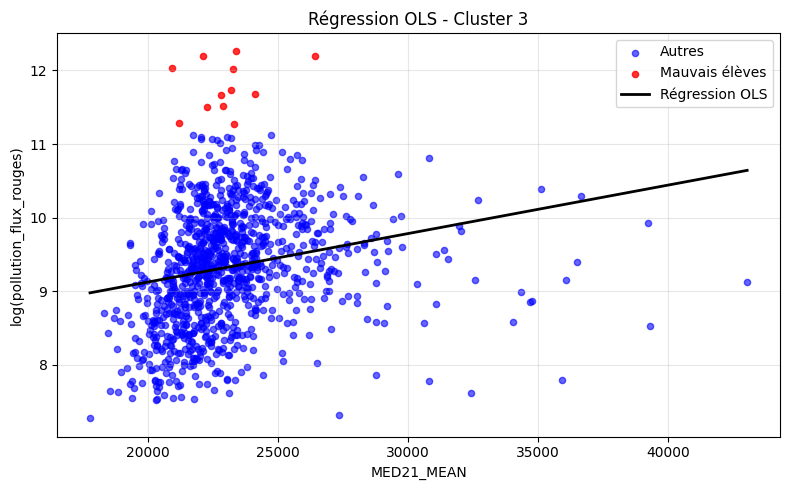

In [108]:
model, data_used = regression_ols_cluster(
    epci_features,
    mauvais_eleves_df=mauvais_eleves_par_cluster,
    cluster_col='cluster',
    cluster_value=3, remove_outliers=True,quantile_threshold=0.9999,
    log_y=True
)


                              OLS Regression Results                             
Dep. Variable:     pollution_flux_rouges   R-squared:                       0.157
Model:                               OLS   Adj. R-squared:                  0.156
Method:                    Least Squares   F-statistic:                     165.7
Date:                   Sun, 11 May 2025   Prob (F-statistic):           6.83e-35
Time:                           00:01:33   Log-Likelihood:                -1022.3
No. Observations:                    893   AIC:                             2049.
Df Residuals:                        891   BIC:                             2058.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8245 

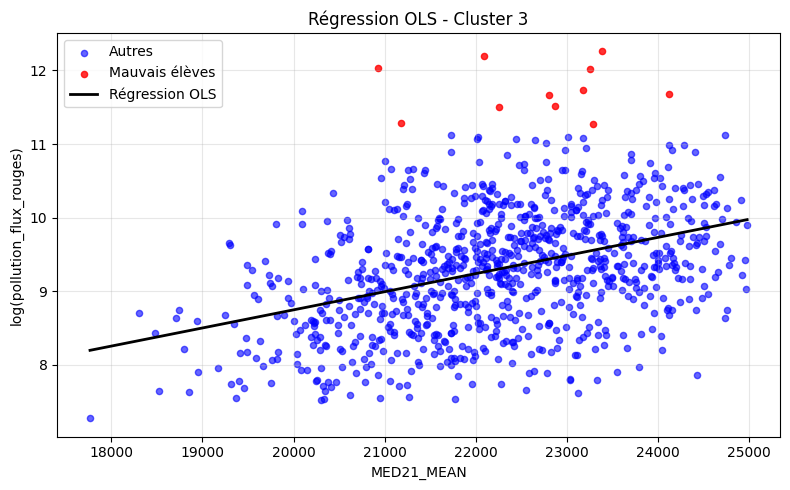

In [109]:
model, data_used = regression_ols_cluster(
    epci_features,
    mauvais_eleves_df=mauvais_eleves_par_cluster,
    cluster_col='cluster',
    cluster_value=3, x_min=10000,
    x_max=25000, remove_outliers=True,
    quantile_threshold=0.9999,
    log_y=True
)
